In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.style.core import available

In [4]:
# 1. Make classification data and get it ready

In [5]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [6]:
len(X), len(y)

(1000, 1000)

In [7]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [8]:
circles = pd.DataFrame({
    "X1":X[:, 0],
    "X2":X[:, 1],
    "label": y
})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


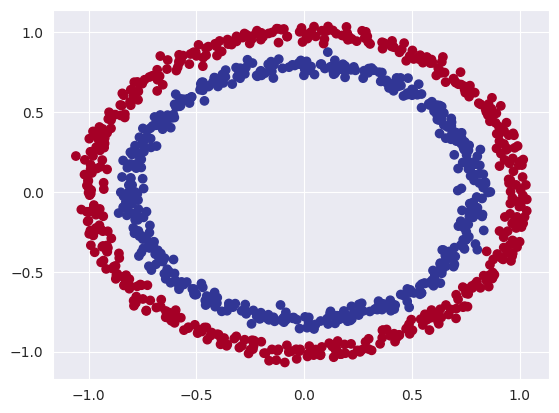

In [9]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

Note: small dataset for experimenting something is called toy dataset.

In [10]:
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. building the classifier model.
1. Setup device agnostic code so the code will run on gpu if there are available
2. Construct a model (by subclassing nn.module)
3. Defining loss function and optimizer
4. Create training and test loop

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
class CircleModule(nn.Module):
    def __init__(self) :
        super().__init__()
        self.input_layer = nn.Linear(in_features=X.shape[1], out_features=1) #taking in 2 features and outputs 1 feature
        self.layer1 = nn.Linear(in_features=1, out_features=1)
    # 3. defining a forward pass
    def forward(self, x):
        return self.layer1(self.input_layer(x)) # X goes into input_layer and then goes into layer1

#4. instantiate the model instance and send it to the target device
model_0 = CircleModule().to(device)
model_0

CircleModule(
  (input_layer): Linear(in_features=2, out_features=1, bias=True)
  (layer1): Linear(in_features=1, out_features=1, bias=True)
)

In [20]:
next(model_0.parameters()).device

device(type='cuda', index=0)

Sequential approach

In [21]:
model_1 = nn.Sequential(
    nn.Linear(in_features=X.shape[1], out_features=1),
    nn.Linear(in_features=1, out_features=1),
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Linear(in_features=1, out_features=1, bias=True)
)

Sequential inside of the class module style code

In [22]:
class CircleModule(nn.Module):
    def __init__(self) :
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(in_features=X.shape[1], out_features=1),
            nn.Linear(in_features=1, out_features=1)
        )
    # 3. defining a forward pass
    def forward(self, x):
        return linear_model(x) # X goes into input_layer and then goes into layer1

#4. instantiate the model instance and send it to the target device
model_0 = CircleModule().to(device)
model_0

CircleModule(
  (linear_model): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [23]:
model_1.state_dict()

OrderedDict([('0.weight', tensor([[ 0.2850, -0.6218]], device='cuda:0')),
             ('0.bias', tensor([0.4030], device='cuda:0')),
             ('1.weight', tensor([[0.8904]], device='cuda:0')),
             ('1.bias', tensor([0.1971], device='cuda:0'))])

In [29]:
#predictions
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))
print(f"length of preds are: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"length of test is: {len(y_test)}, Shape: {y_test.shape}")
print(f"First 10 preds: {torch.round(untrained_preds[:10])}")
print(f"First 10 test: {y_test[:10]}")

length of preds are: 200, Shape: torch.Size([200, 1])
length of test is: 200, Shape: torch.Size([200])
First 10 preds: tensor([[0.],
        [0.],
        [1.],
        [-0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')
First 10 test: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [31]:
# this is basically combination of sigmoid activation and cross entropy which provides more stability
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [32]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum.item
    acc = (correct / len(y_pred)) * 100
    return acc